In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from sage.all import *
import os

In [13]:
IGNORE_VERTEX = 65536

In [14]:
with open(os.path.join('adjacency_lists', 'austin_test.txt'), 'r') as f:
    lines = f.readlines()
    num_vertices, num_edges = map(int, lines.pop(0).strip().split(' '))
    adjacency_list = [set() for _ in range(num_vertices)]
    min_number = min(map(int, " ".join(lines).split()))
    print(min_number)
    for v, line in enumerate(lines):
        neighbors = map(int, line.strip().split(' '))
        for u in neighbors:
            if u == IGNORE_VERTEX:
                continue
            adjacency_list[v].add(u - min_number)
            adjacency_list[u - min_number].add(v)
    print(adjacency_list)

0
[{8, 6, 7}, {8, 6, 7}, {8, 11, 6}, {9, 10, 7}, {9, 10, 11}, {9, 10, 11}, {0, 1, 2}, {0, 1, 3}, {0, 1, 2}, {3, 4, 5}, {3, 4, 5}, {2, 4, 5}]


[[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]]


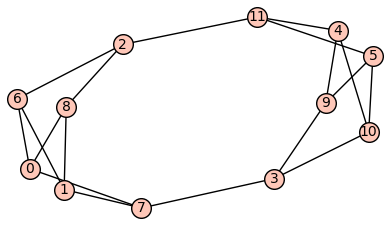

In [15]:
adjacency_matrix = [ [0 for i in range(num_vertices)] for j in range(num_vertices)]
for i in range(num_vertices):
    for j in adjacency_list[i]:
        adjacency_matrix[i][j] = 1
        adjacency_matrix[j][i] = 1
print(adjacency_matrix)

# load into sagemath and calculate the genus
g = Graph(matrix(adjacency_matrix), format='adjacency_matrix')
g.show()

In [16]:
solution = [
    [0, 6, 2, 8, 1, 7, 0], 
    [3, 9, 4, 11, 5, 10, 3], 
    [0, 8, 2, 11, 4, 10, 5, 9, 3, 7, 1, 6, 0], 
    [0, 7, 3, 10, 4, 9, 5, 11, 2, 6, 1, 8, 0], 
]
# solution = [[x - 1 for x in y] for y in solution] # convert 1-indexed to 0-indexed

In [17]:
len(solution)

4

In [18]:
cycles = [ c for c in g.to_directed().all_simple_cycles(max_length=max(map(len, solution))) ]
print(len(cycles))

174


In [19]:
# only valid cycles and no duplicates edges
edges = set()
for c in solution:
    for i in range(len(c) - 1):
        assert (c[i], c[i + 1]) not in edges, "Duplicate edge " + str(c[i]) + " " + str(c[i + 1])
        edges.add((c[i], c[i + 1]))
    assert c in cycles

In [20]:
# no duplicate cycles in the solution
for i, c1 in enumerate(solution):
    for j, c2 in enumerate(solution):
        if i == j:
            continue
        if list(reversed(c1)) == c2:
            continue
        try:
            offset = c2.index(c1[0])
        except ValueError:
            continue
        assert c2[offset:] + c2[:offset] != c1, "Duplicate cycles " + str(c1) + " " + str(c2)

In [6]:
def x_in_y(query, base):
    try:
        l = len(query)
    except TypeError:
        l = 1
        query = type(base)((query,))

    for i in range(len(base)):
        if base[i:i+l] == query:
            return True
    return False

# test cases 
assert x_in_y((1, 2, 3), (1, 2, 3, 4))
assert x_in_y((1, 2, 3), (4, 1, 2, 3))
assert not x_in_y((1, 2, 3), (1, 2, 4, 3))
assert x_in_y([0, 61, 60], [0, 61, 60, 59, 42, 41, 40, 39, 68, 69, 0])

In [22]:
# make sure if vertices i, j, k occur in the solution, k, j, i don't
for c in solution:
    c = c.copy() + [c[1]]
    for i in range(len(c) - 2):
        for c2 in solution:
            c2 = c2.copy() + [c2[1]]
            assert not x_in_y([c[i + 2], c[i + 1], c[i]], c2), "Found " + str(c[i]) + " " + str(c[i + 1]) + " " + str(c[i + 2]) + " in " + str(c2)

In [23]:
vertex_uses = g.degree_sequence()
for c in solution:
    for v in c[:-1]:
        vertex_uses[v] -= 1
print("Missing vertex uses:", vertex_uses)
assert all([v == 0 for v in vertex_uses]), "All vertices should be used fully"

Missing vertex uses: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
# convert edges list to adjacency list
al = [[] for _ in range(g.num_verts())]
for e in g.edges():
    al[e[0]].append(e[1])
    al[e[1]].append(e[0])

# check if every edge is used exactly once by removing them from the adjacency list
for c in solution:
    for i in range(len(c) - 1):
        assert c[i + 1] in al[c[i]], "Edge " + str(c[i]) + " " + str(c[i + 1]) + " not in adjacency list"
        al[c[i]].remove(c[i + 1])
assert all([len(v) == 0 for v in al]), "All edges should be used exactly once"

In [25]:
# verify the rotation system (sorted adjacency list)
adj = [[] for _ in range(num_vertices)]
pairs = [[] for _ in range(num_vertices)]
for c in solution:
    ce = c[:-1]
    for i in range(len(c) - 1):
        pairs[c[i]].append((ce[i - 1], c[i + 1]))
print(pairs)
for i, p in enumerate(pairs):
    u, v = p.pop(0)
    s = u
    adj[i].append(u)
    while v != s:
        adj[i].append(v)
        u, v = list(filter(lambda x: x[0] == v, p))[0]
        p.remove((u, v))
    assert len(p) == 0, "Invalid rotation system"
print(adj)
print("Rotation system is valid")

[[(7, 6), (6, 8), (8, 7)], [(8, 7), (7, 6), (6, 8)], [(6, 8), (8, 11), (11, 6)], [(10, 9), (9, 7), (7, 10)], [(9, 11), (11, 10), (10, 9)], [(11, 10), (10, 9), (9, 11)], [(0, 2), (1, 0), (2, 1)], [(1, 0), (3, 1), (0, 3)], [(2, 1), (0, 2), (1, 0)], [(3, 4), (5, 3), (4, 5)], [(5, 3), (4, 5), (3, 4)], [(4, 5), (2, 4), (5, 2)]]
[[7, 6, 8], [8, 7, 6], [6, 8, 11], [10, 9, 7], [9, 11, 10], [11, 10, 9], [0, 2, 1], [1, 0, 3], [2, 1, 0], [3, 4, 5], [5, 3, 4], [4, 5, 2]]
Rotation system is valid


In [26]:
assert False, "Proceed to visually inspect the solution"

AssertionError: Proceed to visually inspect the solution

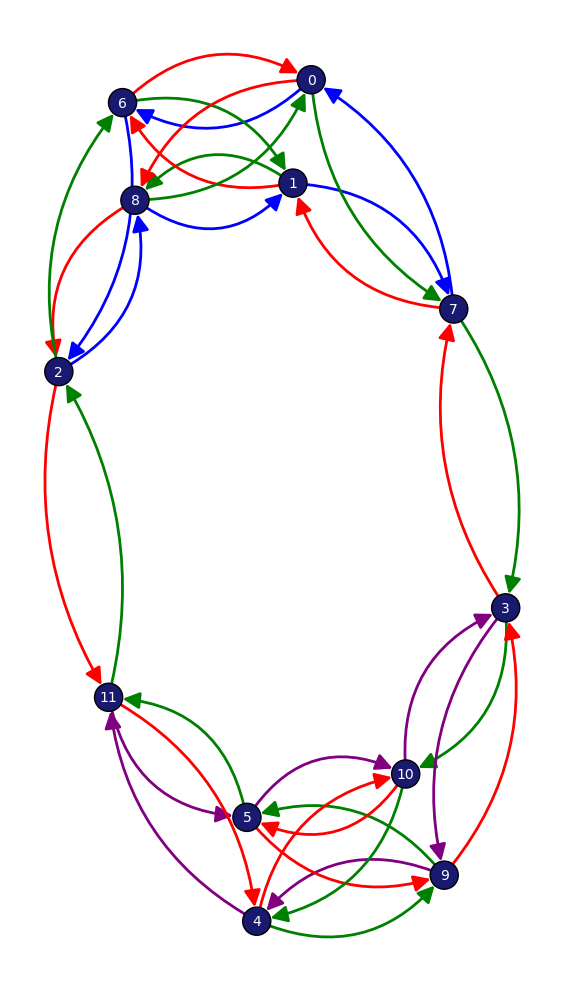

In [27]:
g_directed = g.to_directed()

def is_in_cycle(e, cycle):
    try:
        i = cycle.index(e[0])
        j = cycle.index(e[1])

        if i + 1 == j or (i == len(cycle) - 2 and j == 0):
            return True
        else:
            return False
    except ValueError:
        return False

for e in g_directed.edges():
    g_directed.set_edge_label(e[0], e[1], 0)
    for i, c in enumerate(solution):
        if is_in_cycle(e, c):
            g_directed.set_edge_label(e[0], e[1], i + 1)

p = g_directed.plot(
    edge_colors=g_directed._color_by_label({
        0: "black", 
        1: "blue", 
        2: "purple", 
        3: "red", 
        4: "green", 
        5: "orange", 
        6: "yellow",
        7: "brown",
        8: "pink",
        9: "cyan",
        10: "magenta",
        11: "grey",
        12: "lightblue",
        13: "lightgreen",
        14: "teal",
        15: 'salmon',
        16: 'navy',
        17: 'gold',
        18: 'lime',
        19: 'indigo',
        20: 'maroon',
        21: 'olive',
    }), 
    vertex_size=70,
    vertex_color="midnightblue",
    transparent=True,
)
for object in p._objects:
    if isinstance(object, sage.plot.text.Text):
        object._options['rgbcolor'] = (1, 1, 1)
p.show(figsize=(10, 10))

# export as PDF
# p.save("Johnson5-2_Genus1Embedding.pdf", figsize=(14, 14))

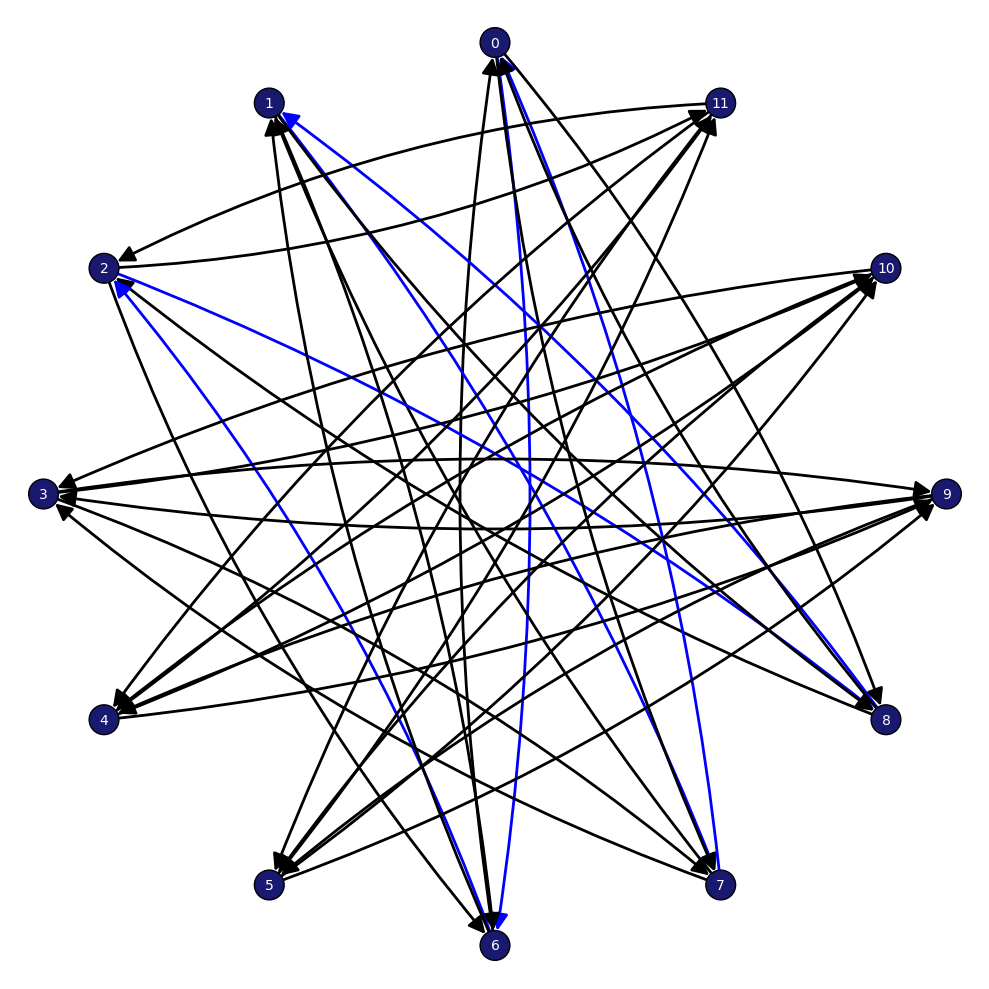

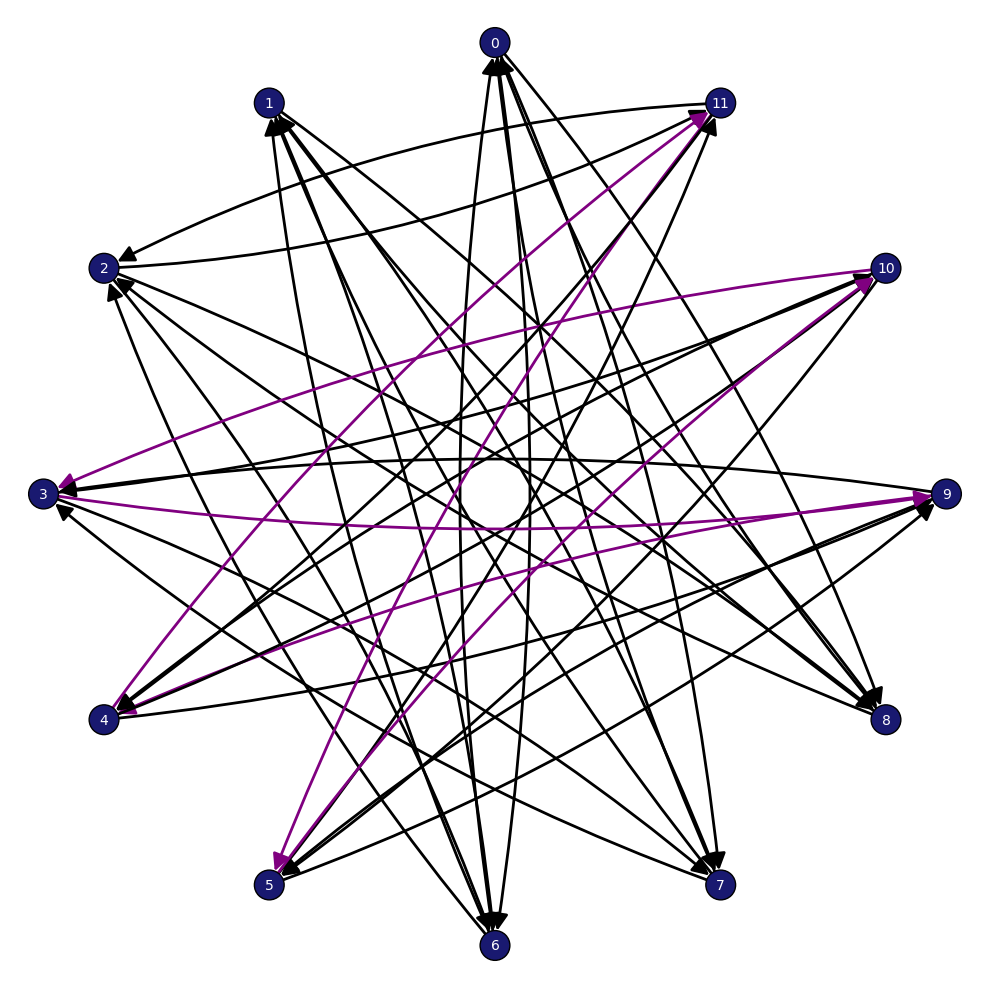

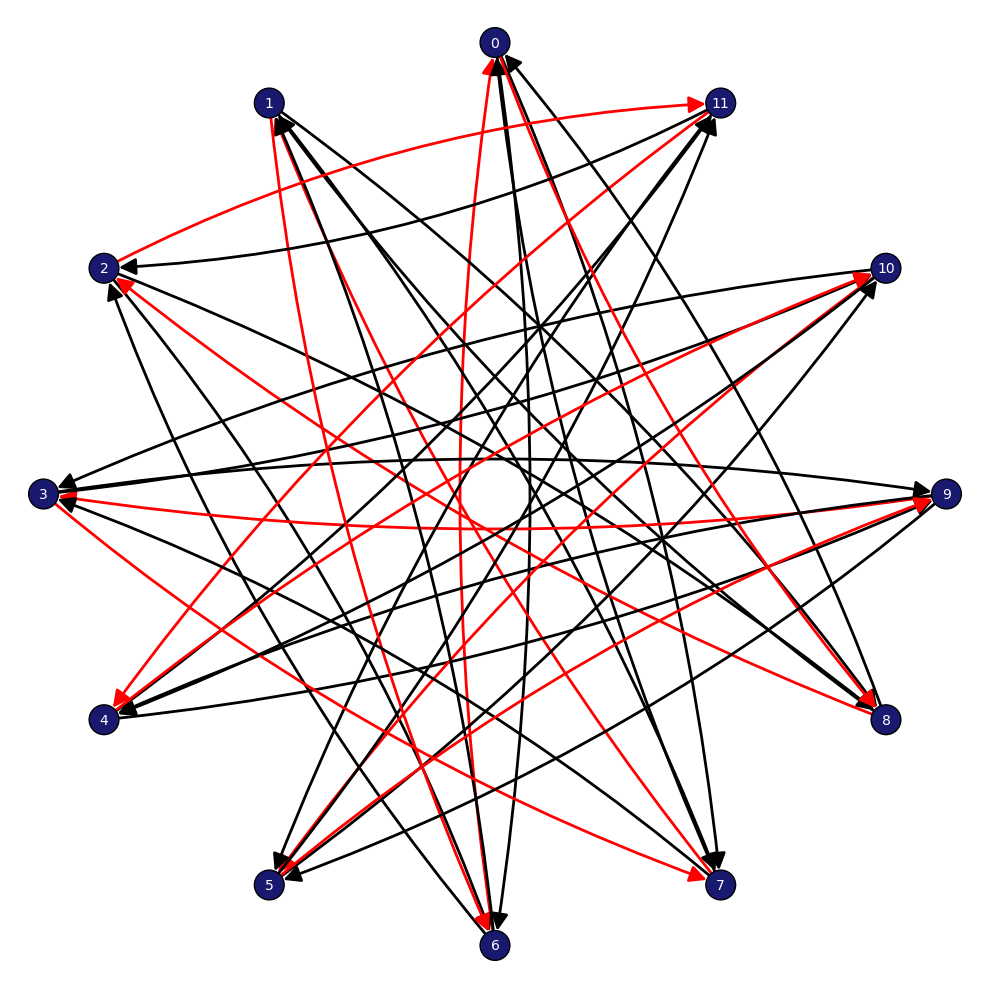

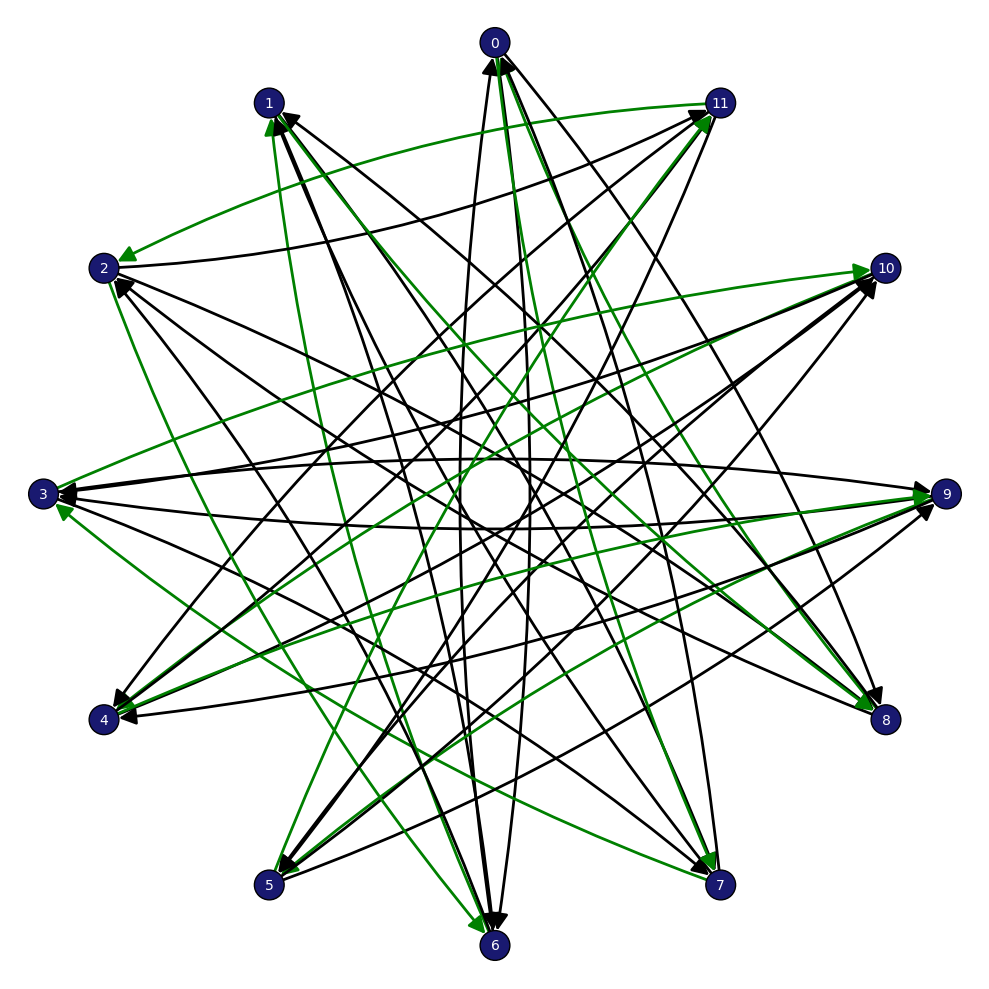

In [28]:
g_directed.layout()
pos = g_directed.get_pos()
for i, c in enumerate(solution):
    for e in g_directed.edges():
        g_directed.set_edge_label(e[0], e[1], 0)
        if is_in_cycle(e, c):
            g_directed.set_edge_label(e[0], e[1], i + 1)

    g_directed.set_pos(pos)

    p = g_directed.plot(
        edge_colors=g_directed._color_by_label({
            0: "black", 
            1: "blue", 
            2: "purple", 
            3: "red", 
            4: "green", 
            5: "orange", 
            6: "yellow",
            7: "brown",
            8: "pink",
            9: "cyan",
            10: "magenta",
            11: "grey",
            12: "lightblue",
            13: "lightgreen",
            14: "teal",
            15: 'salmon',
            16: 'navy',
            17: 'gold',
            18: 'lime',
            19: 'indigo',
            20: 'maroon',
            21: 'olive',
        }), 
        vertex_size=70,
        vertex_color="midnightblue",
        transparent=True,
        pos=pos,
        layout='circular',
    )
    for object in p._objects:
        if isinstance(object, sage.plot.text.Text):
            object._options['rgbcolor'] = (1, 1, 1)
    p.show(figsize=(10, 10))

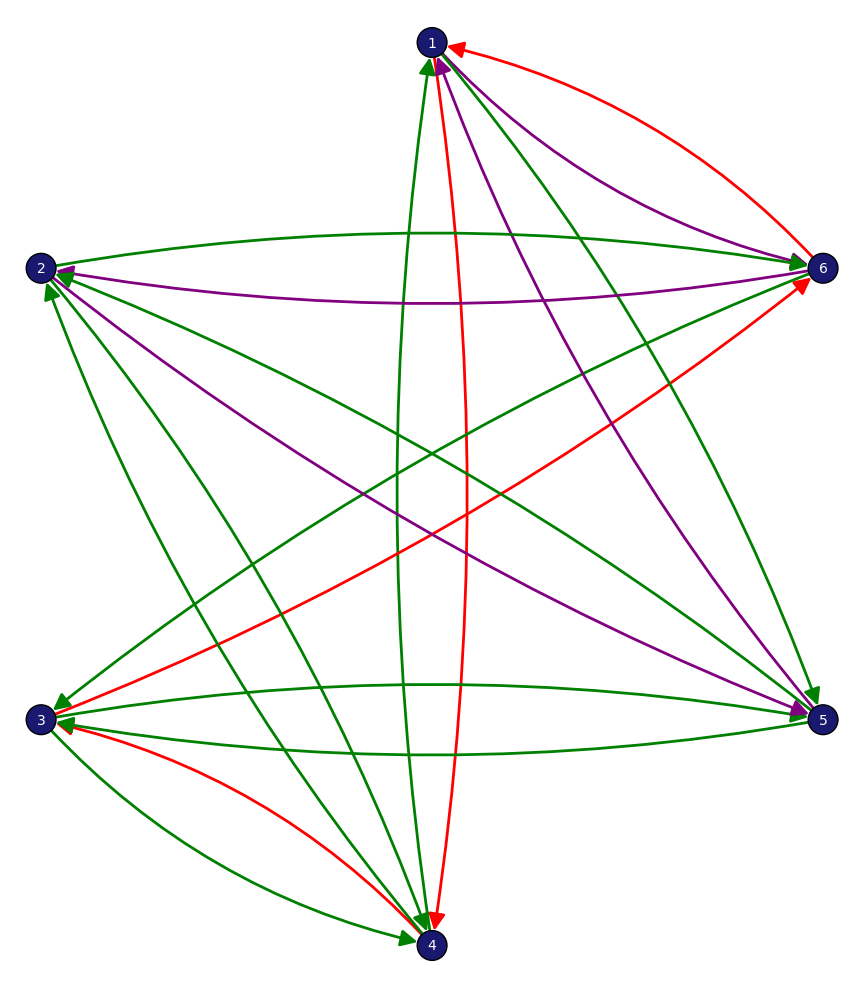

In [31]:
def is_in_cycle(e, cycle):
    i_s = [i for i, x in enumerate(cycle) if x == e[0]]
    j_s = [i for i, x in enumerate(cycle) if x == e[1]]

    for i in i_s:
        for j in j_s:
            if i + 1 == j or (i == len(cycle) - 2 and j == 0):
                return True
    return False

G = graphs.CompleteBipartiteGraph(3,3)
old_labels = G.vertices()
new_labels = list(range(1, len(old_labels)+1))
label_map = dict(zip(old_labels, new_labels))
G = G.relabel(label_map, inplace=False)
g_directed = G.to_directed()
g_directed.layout()
pos = g_directed.get_pos()
solution = [
    [2, 5, 1, 6, 2],
    [6, 1, 4, 3, 6],
    [5, 2, 4, 1, 5, 3, 4, 2, 6, 3, 5]
]
for e in g_directed.edges():
    g_directed.set_edge_label(e[0], e[1], 0)
    for i, c in enumerate(solution):
        if is_in_cycle(e, c):
            g_directed.set_edge_label(e[0], e[1], i + 2)

g_directed.set_pos(pos)

p = g_directed.plot(
    edge_colors=g_directed._color_by_label({
        0: "black", 
        1: "blue", 
        2: "purple", 
        3: "red", 
        4: "green", 
        5: "orange", 
        6: "yellow",
        7: "brown",
        8: "pink",
        9: "cyan",
        10: "magenta",
        11: "grey",
        12: "lightblue",
        13: "lightgreen",
        14: "teal",
        15: 'salmon',
        16: 'navy',
        17: 'gold',
        18: 'lime',
        19: 'indigo',
        20: 'maroon',
        21: 'olive',
    }), 
    vertex_size=70,
    vertex_color="midnightblue",
    transparent=True,
    pos=pos,
    layout='circular',
)
for object in p._objects:
    if isinstance(object, sage.plot.text.Text):
        object._options['rgbcolor'] = (1, 1, 1)
p.show(figsize=(10, 10))